In [1]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import esmvalcore.preprocessor
import xarray as xr
import xesmf as xe
from tqdm import tqdm
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt
import dask
from nc_processing import calc_spatial_mean

def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        if ocean:
            ds = replace_x_y_nominal_lat_lon(rename_cmip6(xr.open_mfdataset(files)))
        else: 
            ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True))
    return ds

def read_in_ens_mean(dirs, ocean = False):
    """ returns (1) the ensemble mean dataset, and (2) the number of ensemble members """
    
    files = []
    for dir in dirs:
        for x in os.listdir(dir):
            files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
    return ds, n_ens

In [2]:
QE_scens = ['abrupt-0p5xCO2',
            'abrupt-2xCO2',
            'abrupt-4xCO2']

Tr_scens = ['ssp245',
            'G6sulfur']

mod = 'IPSL-CM6A-LR'


var = 'tas'
table = 'Amon'
dirs = []


for scen in QE_scens + Tr_scens:       
    for x in glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/r1i*/{t}/{v}/*/latest/'.format(
                    m=mod, s=scen, t=table, v=var)): 
        dirs.append(x)

df = pd.DataFrame({'Scenario':QE_scens + Tr_scens, 'folder': dirs})
df

,Scenario,folder
0,abrupt-0p5xCO2,/badc/cmip6/data/CMIP6/CFMIP/IPSL/IPSL-CM6A-LR...
1,abrupt-2xCO2,/badc/cmip6/data/CMIP6/CFMIP/IPSL/IPSL-CM6A-LR...
2,abrupt-4xCO2,/badc/cmip6/data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/...
3,ssp245,/badc/cmip6/data/CMIP6/ScenarioMIP/IPSL/IPSL-C...
4,G6sulfur,/badc/cmip6/data/CMIP6/GeoMIP/IPSL/IPSL-CM6A-L...


In [3]:
### make a list of models with both abrupt and transient runs available
abrupt_scen = 'abrupt-2xCO2'
transient_scen = 'ssp585'
mod = 'UKESM1-0-LL'
#mod = 'CESM2-WACCM'
#mod = 'IPSL-CM6A-LR'
var = 'tas'
table = 'Amon'




dirs=[]
for x in glob.glob('/badc/cmip6/data/CMIP6/*/*/*/{s}/r1i*/{t}/{v}/*/latest/'.format(s=abrupt_scen, m=mod, t=table, v=var)): 
    dirs.append(x)


mods = []
for x in dirs:
    mod = x.split('/')[7]
    folder_transient = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/r1i*/{t}/{v}/*/latest/'.format(m=mod, s=transient_scen, t=table, v=var))
    if len(folder_transient) > 0:
        mods.append(mod)

mods

['CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'GISS-E2-1-G']

In [21]:

def main(mod, var='tas', table='Amon'):
    """ produce a spatial nc file, with map of difference
    between time-mean variable under abrupt 2xco2 (after 30 years transition)
    and variable during transient period at the same gmst """


    folder_abrupt_tas = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/tas/*/latest/'.format(
        m=mod, s=abrupt_scen))
    folder_transient_tas = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/tas/*/latest/'.format(
        m=mod, s=transient_scen))
    
    folder_abrupt_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
        m=mod, s=abrupt_scen, t=table, v=var))
    folder_transient_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
        m=mod, s=transient_scen, t=table, v=var))
        
    ds_qe, n_ens_qe = read_in_ens_mean(folder_abrupt_tas)
    
    drop_first_n_years = 50
    ds_qe = ds_qe.isel(time=slice(drop_first_n_years*12, None)) #
    
    #now calc global mean temp at qe:
    gmst = calc_spatial_mean(ds_qe.tas.mean(dim='time'), lon_name="x", lat_name="y")
    print(gmst.values)
    
    
    #now find the x-year transient period with the same gmst:
    tr_period_length = 21
    ds_tr, n_ens_tr = read_in_ens_mean(folder_transient_tas)
    tr_gmst = calc_spatial_mean(ds_tr.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': tr_gmst.year.values,
                       'gmst': tr_gmst.values})
    
    df['gmst_rolling'] = df['gmst'].rolling(window=tr_period_length, center=True).mean()
    df['gmst_roll_diff'] = np.abs(df['gmst_rolling'] - gmst.values)
    
    print(df[df.gmst_roll_diff == df.gmst_roll_diff.min()])

    print('N_ens QE: '+str(n_ens_qe))
    print('N_ens transient: '+str(n_ens_tr))
          
    crossing_df = df[df.gmst_roll_diff == df.gmst_roll_diff.min()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(tr_period_length-1)/2), int(crossing_year+(tr_period_length-1)/2)]
    window_years
    
    plt.plot(df['Year'], df['gmst'])
    plt.plot(df['Year'], df['gmst_rolling'])
    plt.axhline(gmst.values)
    plt.axvline(window_years[0])
    plt.axvline(window_years[1])
    plt.show()

    ds_tr_var, n_ens_tr_var = read_in_ens_mean(folder_transient_var)
    ds_tr_window = ds_tr_var.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    tr_map_mean = ds_tr_window.mean(dim=['year'])
        

    ds_qe_var, n_ens_qe_var = read_in_ens_mean(folder_abrupt_var)
    qe_map_mean = ds_qe_var.mean(dim='time')
    
    ### now bootstrap to gauge significance
    ### we take N randomly selected 20 year slices 
    ### and caluclate the std in the means of those slices
    ds_qe_yr = ds_qe_var.groupby("time.year").mean(dim="time")
    ds_list = []
    N = 100
    for i in range(N):
        x = ds_qe_yr.isel(year=np.random.randint(0, ds_qe_yr.year.size, 21))
        x = x.mean(dim='year') 
        x['iter'] = i
        ds_list.append(x)
    
    out_ds = xr.concat(ds_list, dim='iter')
    out_ds_std = out_ds.std(dim='iter')
    
    
    
    anom_map = qe_map_mean - tr_map_mean
    #anom_map.tas.plot()

    
    tr_map_mean.to_netcdf('int_outs/tr_{v}_map_means/{m}.nc'.format(v=var, m=mod))   
    qe_map_mean.to_netcdf('int_outs/qe_{v}_map_means/{m}.nc'.format(v=var, m=mod))
    out_ds_std.to_netcdf('int_outs/qe_{v}_map_boot_stds/{m}.nc'.format(v=var, m=mod))
    anom_map.to_netcdf('int_outs/qe-tr_{v}_map_means/{m}.nc'.format(v=var, m=mod))
    return

In [20]:
var, table = 'pr', 'Amon'
mod, abrupt_scen = 'IPSL-CM6A-LR', 'abrupt-2xCO2'

folder_abrupt_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
        m=mod, s=abrupt_scen, t=table, v=var))
ds = read_in_ens_mean(folder_abrupt_var)
ds

(<xarray.Dataset>
 Dimensions:  (time: 1800, y: 143, x: 144)
 Coordinates:
   * time     (time) object 1850-01-16 12:00:00 ... 1999-12-16 12:00:00
   * y        (y) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
   * x        (x) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
 Data variables:
     pr       (time, y, x) float32 dask.array<chunksize=(1800, 143, 144), meta=np.ndarray>,
 1)

CanESM5
289.8372366254431
    Year        gmst  gmst_rolling  gmst_roll_diff
28  2043  289.807369    289.840893        0.003656
N_ens QE: 1
N_ens transient: 52


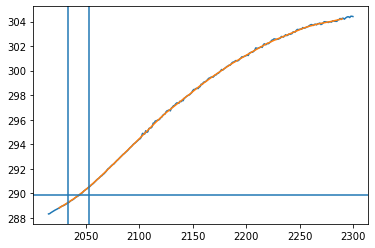

IPSL-CM6A-LR
288.8579269081228
    Year        gmst  gmst_rolling  gmst_roll_diff
34  2049  288.878759    288.873105        0.015178
N_ens QE: 1
N_ens transient: 7


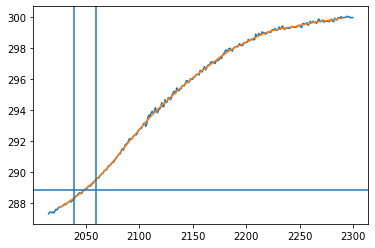

HadGEM3-GC31-LL
290.19510577718745
    Year        gmst  gmst_rolling  gmst_roll_diff
41  2056  290.347672    290.222402        0.027296
N_ens QE: 2
N_ens transient: 8


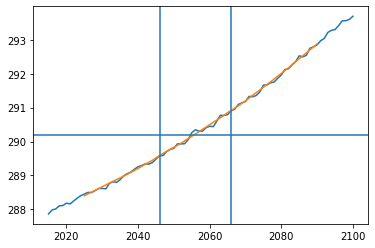

GISS-E2-1-G
288.95394110743115
    Year        gmst  gmst_rolling  gmst_roll_diff
26  2041  289.128586    288.969777        0.015836
N_ens QE: 3
N_ens transient: 4


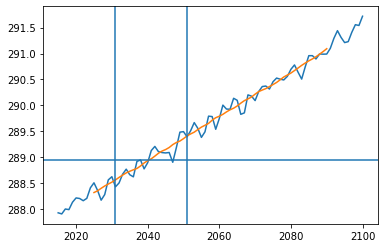

In [22]:
for mod in mods:
    print(mod)
    main(mod, var='pr')

In [8]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

/tmp/ipykernel_649/3413604252.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


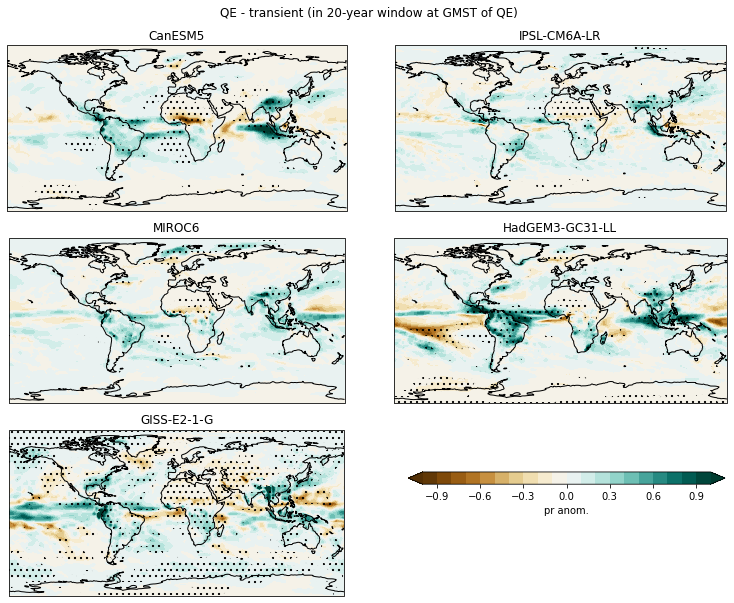

In [32]:
var = 'pr'

conversion_units = {'tas':1, 
                    'pr':86400}
cmaps = {'tas':'RdBu_r', 
         'pr':'BrBG'}

folder_QE = 'int_outs/qe_{}_map_means/'.format(var)
folder_Tr = 'int_outs/tr_{}_map_means/'.format(var)
folder_Std = 'int_outs/qe_{}_map_boot_stds/'.format(var)

# Define the contour levels to use in plt.contourf
if var == 'tas':
    clevs=np.arange(-2.2,2.5,0.4) 
elif var == 'pr':
    clevs=np.arange(-1,1.1,0.1) 


nrows=3
ncols=2
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for i,model in enumerate(mods):

        
        QE = xr.open_dataset(folder_QE+'/'+model+'.nc')
        Tr = xr.open_dataset(folder_Tr+'/'+model+'.nc')
        ds = QE - Tr
        data = ds[var].values
        abs_data = np.absolute(data)
        STD = xr.open_dataset(folder_Std+'/'+model+'.nc')
        sig_mask = xr.where(abs_data > 2*STD[var].values, 1, 0)
    
        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds['x'])
        sig_mask,lons=add_cyclic_point(sig_mask,coord=ds['x'])
    
        # Contour plot
        cs=axs[i].contourf(lons,ds['y'],data*conversion_units[var],
                           clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=cmaps[var],
                           extend='both')

        ##adding hatches:
        cs_hatch = axs[i].contourf(lons,ds['y'],sig_mask,
                                   levels=[0, 0.5, 1.2], colors='none',
                                   hatches=[None,'..', '..'],
                                   extend='neither')

        # Title each subplot with the name of the model
        axs[i].set_title(model)

        # Draw the coastines for each subplot
        axs[i].coastlines()

# Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.55, 0.2, 0.4, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='{} anom.'.format(var))

# Add a big title at the top
plt.suptitle('QE - transient (in 20-year window at GMST of QE)')
plt.tight_layout()
plt.savefig('Figures/QE2xCO2_vs_tr_anom_{}.jpg'.format(var), dpi=450)

In [27]:
ds.pr

<xarray.DataArray 'pr' (y: 90, x: 144)>
array([[-4.16224566e-08, -4.16224566e-08, -4.16224566e-08, ...,
        -4.16224566e-08, -4.16224566e-08, -4.16224566e-08],
       [-1.26900773e-07, -1.53737119e-07, -1.51103677e-07, ...,
        -1.66949121e-07, -1.58387365e-07, -1.36833137e-07],
       [-1.33292360e-07, -1.23706059e-07, -1.07689175e-07, ...,
        -1.70857675e-07, -1.66009158e-07, -1.47002083e-07],
       ...,
       [-1.71314241e-07, -1.36465133e-07, -1.24250619e-07, ...,
        -2.60619345e-07, -2.24197720e-07, -1.69809937e-07],
       [ 5.17793524e-08,  6.76318450e-08, -6.88978616e-08, ...,
         1.65142410e-07,  8.30741556e-08,  9.72431735e-08],
       [ 8.33902050e-08,  8.33902050e-08,  8.33902050e-08, ...,
         8.33902050e-08,  8.33902050e-08,  8.33902050e-08]], dtype=float32)
Coordinates:
  * y        (y) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * x        (x) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8